## Introduction
(TODO) // keep at the end, the general description of our project

## Background
(TODO) // why we choose this dataset and what we want to get from this dataset (may be combined with Introduction)

## Over view of the data set
(TODO) // how the dataset looks like, i.e. meaning of each fields

## Methodology
(TODO) // explain what kind of methods/techniques will apply to this dataset

### Data pre-processing
(TODO) // put the correlation, drop attributes process into here (need to organize the steps and graphs)

####  mention what factors we keep: Y = latestPrice, X = ['livingAreaSqFt','numOfBathrooms', 'avgSchoolRating', 'numOfBedrooms', 'numOfHighSchools', 'MedianStudentsPerTeacher']

this is our linear regression model.

### Linear regression
First, we use linear regression to estimate the house price(response variable) using the selected attributes(explanatory variables) from this dataset. We assume the relationship between the explanatory variables and response variable. We skip the process of simple linear regression and start with multivarible linear regression.

In [1]:
import pandas as pd
import seaborn as sb
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

from statsmodels.regression.linear_model import OLS

df = pd.read_csv('../austinHousingData.csv')

df_filtered = df[['livingAreaSqFt','numOfBathrooms', 'avgSchoolRating', 'numOfBedrooms', 'numOfHighSchools', 'MedianStudentsPerTeacher', 'latestPrice']]

df_filtered

X = df_filtered.drop("latestPrice", axis=1)
Y = df_filtered["latestPrice"]

lreg = LinearRegression()

model = lreg.fit(X, Y)


model = OLS(Y, X)
result = model.fit()
#result.params


In [2]:
import matplotlib.pyplot as plt
fittedValues = result.fittedvalues
residuals = result.resid

residDF = pd.DataFrame(fittedValues, columns=['fittedValues'])
residDF['residuals'] = residuals

<AxesSubplot:xlabel='fittedValues', ylabel='residuals'>

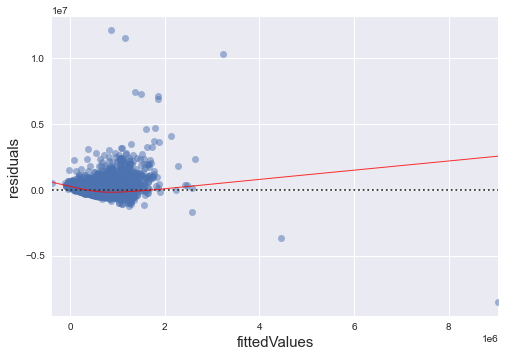

In [3]:
plt.style.use('seaborn')
plt.rc('font', size=14)
plt.rc('figure', titlesize=18)
plt.rc('axes', labelsize=15)
plt.rc('axes', titlesize=18)
resid_plot = plt.figure()
resid_plot = sb.residplot(x = "fittedValues", y = "residuals", data=residDF,
                          lowess=True,
                          scatter_kws={'alpha': 0.5},
                          line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

resid_plot

At the first glance, we see there are several outliers scatters around the edge of the graph. We check those samples and assume there might be mistakes on it, such as a house with 2137 squared feet has 27 bathrooms. Also, the residual graph shows our dataset is not normal and not equal variance.

<AxesSubplot:xlabel='fittedValues', ylabel='residuals'>

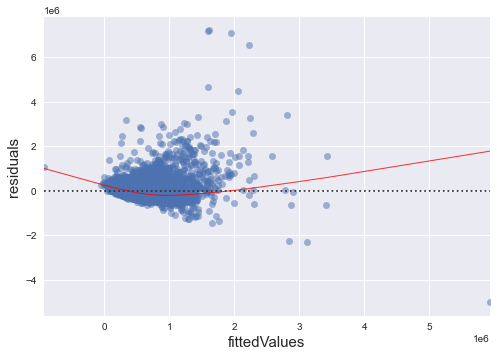

In [4]:
dropRows = [705,1399,14275,2316,2838] # outliers rows
Xnew = X.drop(dropRows, axis=0)
Ynew = Y.drop(dropRows, axis=0)

#model = lreg.fit(Xnew, Ynew)
model = OLS(Ynew, Xnew)
result = model.fit()
result.params

fittedValues = result.fittedvalues
residuals = result.resid
residDF = pd.DataFrame(fittedValues, columns=['fittedValues'])
residDF['residuals'] = residuals
residDF

resid_plot = sb.residplot(x = "fittedValues", y = "residuals", data=residDF,
                          lowess=True,
                          scatter_kws={'alpha': 0.5},
                          line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

resid_plot

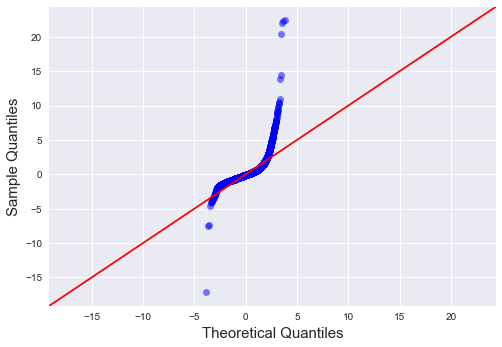

In [5]:
from statsmodels.graphics.gofplots import ProbPlot

norm_residuals = result.get_influence().resid_studentized_internal
QQ = ProbPlot(norm_residuals)
plotQQ = QQ.qqplot(line='45', alpha=0.5, color='blue', lw=1)

After remove several outliers, our dataset is still not normal and equal variance in full factor regression model. So, We try to transform the dataset.

<AxesSubplot:xlabel='fittedValues', ylabel='residuals'>

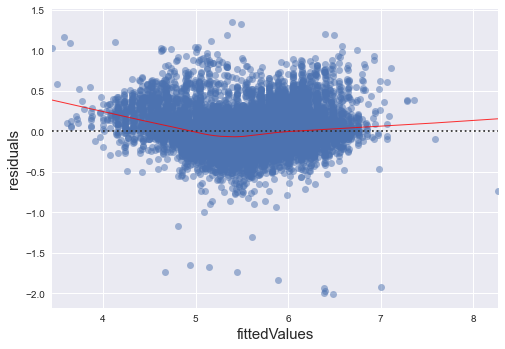

In [6]:
# keep log10
import numpy as np

dropRows = [705,1399,14275,2316,2838] # outliers rows
Xnew = X.drop(dropRows, axis=0)
Ynew = Y.drop(dropRows, axis=0)

Ynew = np.log10(Ynew)
#model = lreg.fit(Xnew, Ynew)
model = OLS(Ynew, Xnew)
result = model.fit()
fittedValues = result.fittedvalues
residuals = result.resid
residDF = pd.DataFrame(fittedValues, columns=['fittedValues'])
residDF['residuals'] = residuals

resid_plot = sb.residplot(x = "fittedValues", y = "residuals", data=residDF,
                          lowess=True,
                          scatter_kws={'alpha': 0.5},
                          line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

resid_plot

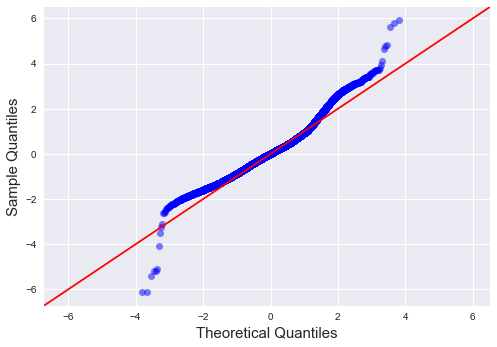

In [7]:
from statsmodels.graphics.gofplots import ProbPlot

norm_residuals = result.get_influence().resid_studentized_internal
QQ = ProbPlot(norm_residuals)
plotQQ = QQ.qqplot(line='45', alpha=0.5, color='blue', lw=1)

With ***log10(Y)*** transformation, the dataset looks better and is suitable to do linear regression. We start verifying how good our model.

$log_{10}(\hat{Y}) = \beta_0 + \beta_1X_1 + \beta_2X_2 + \beta_3X_3 + \beta_4X_4 + \beta_5X_5 + \beta_6X_6$

where:

$X_1=\text{livingAreaSqFt}, X_2=\text{numOfBathrooms}, X_3=\text{avgSchoolRating}, X_4=\text{numOfBedrooms}, X_5=\text{numOfHighSchools}, X_6=\text{MedianStudentsPerTeacher}, X_7=\text{latestPrice}$

We split our dataset to two portions, one for training and another for testing. This can mimic the situation to see how good is our model when fitting new/unseen data.

In [8]:
# training/testing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Xtrain/Xtest: dataframe, Ytrain/Ytest: array
Xtrain, Xtest, Ytrain, Ytest = train_test_split(Xnew, Ynew, train_size = 0.8, random_state = 1)

lreg = LinearRegression()

lregModel = lreg.fit(Xtrain, Ytrain)


print("y-intercept = %.4f" % lregModel.intercept_)
print("coefficient = ", lregModel.coef_)

prediction = lregModel.predict(Xtest)

MSE = mean_squared_error(Ytest, prediction)

print("Mean Square Error (MSE) = %.4f"%MSE)

print("R-square score is: %.4f" %r2_score(Ytest, prediction))

y-intercept = 5.3590
coefficient =  [ 8.95029060e-05  4.50262693e-02  2.58353077e-02 -2.49561851e-02
 -7.10633040e-02 -2.53801629e-03]
Mean Square Error (MSE) = 0.0338
R-square score is: 0.4175


From the result, we obtain the coefficients of our model are:

$log_{10}(\hat{Y})=5.36 + 0.00009X_1 + 0.045X_2 + 0.0258X_3 - 0.025X_4 - 0.071X_5 - 0.00254X_6$

### Polynomial Regression

In [10]:
# polynomial part
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler

def min_max_normalization(x) :
    x_min = min(x)
    x_max = max(x)
    x = [(a - x_min)/(x_max - x_min) for a in x]
    return x

df = pd.read_csv('../austinHousingData.csv')
labelsToRemove = ['zpid', 'city', 'streetAddress', 'latitude', 'longitude', 'description', 'hasGarage', 'numPriceChanges', 'latest_saledate', 'latest_salemonth', 'latest_saleyear', 'latestPriceSource', 'numOfPhotos', 'homeImage']

df.drop(labelsToRemove, axis = 1, inplace=True)

X = df[['numOfBathrooms', 'avgSchoolRating', 'numOfBedrooms', 'numOfHighSchools', 'MedianStudentsPerTeacher']]
Y = df.latestPrice

#for col in X.columns:
#    X[col] = min_max_normalization(X[col])
Y = min_max_normalization(Y)
degree = 2
poly = PolynomialFeatures(degree)
X_poly = poly.fit_transform(X)

tSize = int(len(df)*0.1)
X_poly_train, X_poly_test, Y_train, Y_test = X_poly[:-tSize], X_poly[-tSize:], Y[:-tSize], Y[-tSize:]

model = LinearRegression()
model.fit(X_poly_train, Y_train)

Y_train_pred = model.predict(X_poly_train)
Y_test_pred = model.predict(X_poly_test)

mse_train = mean_squared_error(Y_train,Y_train_pred)
mse_test = mean_squared_error(Y_test,Y_test_pred)
print("Training MSE for degree", degree, "=", mse_train)
print("Testing MSE for degree", degree, "=", mse_test)


Training MSE for degree 2 = 0.0005442839201941888
Testing MSE for degree 2 = 0.0023697046014422357


someone's code, try to figure out how to combine as a function so can check multiple degree polynomial regression without copy/paste lots of code.

need to output some graph to show the result from different degree of model.

** polynomial (may or may not) need transform data, since after log10() transform, the data look like "V" shape, this may be good thing for polynomial.

## Artificial Neural Network
(TODO) // add two? kinds of ANN to learn predict something.(may not necessary restrict to price)

// can try to add other less correlation factors but more meaningful in real life such as "propertyTaxRate", "yearBuilt" to see if the accuracy will increase or not. (someone's code already did that, but it seems impossible to predict the exact "price", any discrepancy will make it inaccurate. Also, need to think how to covert back the [0,1] "price" to normal price.)

## * add anything new here

## Conclusion
(TODO) // what we achieved/found from above machine learning processes. (or can have something about the APP)